# Comparing npSF and tfSF via IB (Simulation 1)

In this notebook we compare npSF and tfSF using the IB, reproducing some of the experiments in [1].

## Setup

We start by importing some libraries:

In [1]:
import numpy as np
import joblib
import sklearn.datasets as ds
import scipy.stats as stats
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import linregress

import tfSF
import npSF

import data.data_creation as D
import IT

We define the parameters of our simulation:

In [2]:
learned_features = 2
n_epochs = 200

IT_bins=30

We define a couple of helper functions: a simple linear regression function and a helper function to compute the tfSF learned representation as a function of the weights. Notice that here, for simplicity, we call the steps of SF implemented using *numpy*; since no learning is now required, using *numpy* saves us the overhead of instantiating a *tensorflow* model.

In [3]:
def linreg(x,y):
    a, b, _, _, _ = stats.linregress(x,y)
    return a*x+b
    

def computeZ(X,W):
    WX = np.dot(W,X.T)
    F = npSF.softabsolute(WX)
    Fsquish, _ = npSF.l2row(F)
    Fhat, _ = npSF.l2row(Fsquish.T)
    Z = Fhat
    return Z

## Simulation 1 from [1]

We now reproduce the results for *Simulation 2* in [1]. We generate random data.

In [4]:
data = D.get_samples_independent_gaussians_2D(n_samples_train=900, n_samples_test=100, 
                                         mu1 = 0.0, sigma1 = .5, mu2 = 0.0, sigma2 =.5)

We train the tfSF module.

In [5]:
tfsf = tfSF.SFilter(n_features=learned_features)
tfsf.fit(data['X_tr'], epochs=n_epochs, batchsize=900)

Epoch 1/200
1/1 [==============================] - 0s 2ms/step - loss: 1192.4104
Epoch 2/200
1/1 [==============================] - 0s 2ms/step - loss: 1148.7743
Epoch 3/200
1/1 [==============================] - 0s 1ms/step - loss: 1147.0591
Epoch 4/200
1/1 [==============================] - 0s 2ms/step - loss: 1151.8470
Epoch 5/200
1/1 [==============================] - 0s 1ms/step - loss: 1152.1833
Epoch 6/200
1/1 [==============================] - 0s 2ms/step - loss: 1149.5598
Epoch 7/200
1/1 [==============================] - 0s 2ms/step - loss: 1147.3867
Epoch 8/200
1/1 [==============================] - 0s 2ms/step - loss: 1146.4941
Epoch 9/200
1/1 [==============================] - 0s 3ms/step - loss: 1146.2975
Epoch 10/200
1/1 [==============================] - 0s 2ms/step - loss: 1146.4900
Epoch 11/200
1/1 [==============================] - 0s 2ms/step - loss: 1146.7141
Epoch 12/200
1/1 [==============================] - 0s 3ms/step - loss: 1146.7507
Epoch 13/200
1/1 [=======

1/1 [==============================] - ETA: 0s - loss: 1144.29 - 0s 2ms/step - loss: 1144.2974
Epoch 102/200
1/1 [==============================] - 0s 2ms/step - loss: 1144.2972
Epoch 103/200
1/1 [==============================] - 0s 1ms/step - loss: 1144.2974
Epoch 104/200
1/1 [==============================] - 0s 1ms/step - loss: 1144.2971
Epoch 105/200
1/1 [==============================] - 0s 2ms/step - loss: 1144.2970
Epoch 106/200
1/1 [==============================] - 0s 3ms/step - loss: 1144.2969
Epoch 107/200
1/1 [==============================] - 0s 8ms/step - loss: 1144.2969
Epoch 108/200
1/1 [==============================] - 0s 975us/step - loss: 1144.2969
Epoch 109/200
1/1 [==============================] - 0s 5ms/step - loss: 1144.2968
Epoch 110/200
1/1 [==============================] - 0s 6ms/step - loss: 1144.2966
Epoch 111/200
1/1 [==============================] - 0s 5ms/step - loss: 1144.2970
Epoch 112/200
1/1 [==============================] - 0s 11ms/step - loss:

1/1 [==============================] - 0s 10ms/step - loss: 1144.2932
Epoch 199/200
1/1 [==============================] - 0s 9ms/step - loss: 1144.2935
Epoch 200/200
1/1 [==============================] - 0s 1ms/step - loss: 1144.2930


We train the npSF module.

In [6]:
npsf = npSF.SFilter()
npsf.setFeatures(learned_features)
npsf.setTrainData(data['X_tr'])
npsf.initializeWeights()
npsf.initialiazeNotebook()
npsf.train()

We plot the loss function to verify that the models converged to a solution.

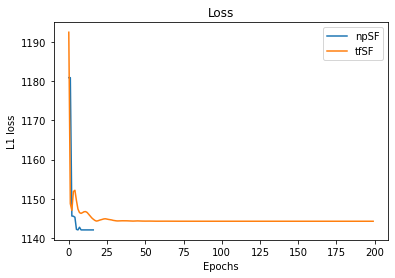

In [7]:
plt.title('Loss'); 
plt.xlabel('Epochs'); 
plt.ylabel('L1 loss');

plt.plot(npsf.notebook['losses'],label='npSF')
plt.plot(tfsf.hist.history['loss'],label='tfSF')
plt.legend()

We compute the information-theoretic statistics of interest (entropy and mutual information) at each iteration.

In [8]:
npWs = npsf.notebook['weights']    
    
np_Z_tes = []; np_MI_XZs = []; np_H_Zs = []  
for W in npWs:
    Z_te = computeZ(data['X_te'],W)
    
    np_Z_tes.append(Z_te)
    np_MI_XZs.append(IT.compute_MI_bin(data['X_te'],Z_te,bins=IT_bins))
    np_H_Zs.append(IT.compute_H_bin(Z_te,bins=IT_bins))


tfWs = tfsf.weights

tf_Z_tes = []; tf_MI_XZs = []; tf_H_Zs = []  
for W in tfWs:
    Z_te = computeZ(data['X_te'],W)
    
    tf_Z_tes.append(Z_te)
    tf_MI_XZs.append(IT.compute_MI_bin(data['X_te'],Z_te,bins=IT_bins))
    tf_H_Zs.append(IT.compute_H_bin(Z_te,bins=IT_bins))

In [9]:
Z_trs = []
for W in tfWs:
    Z_tr = computeZ(data['X_tr'],W)
    Z_trs.append(Z_tr)

We plot entropy and mutual information.

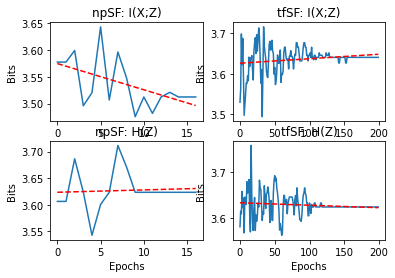

In [10]:
_,ax = plt.subplots(2,2)

ax[0,0].plot(np_MI_XZs)
ax[0,0].set_title('npSF: I(X;Z)')
ax[0,0].set_xlabel('Epochs')
ax[0,0].set_ylabel('Bits')
ax[0,0].plot(linreg(np.arange(len(np_MI_XZs)),np_MI_XZs),'r--')

ax[0,1].plot(tf_MI_XZs)
ax[0,1].set_title('tfSF: I(X;Z)')
ax[0,1].set_xlabel('Epochs')
ax[0,1].set_ylabel('Bits')
ax[0,1].plot(linreg(np.arange(n_epochs),tf_MI_XZs),'r--')

ax[1,0].plot(np_H_Zs)
ax[1,0].set_title('npSF: H(Z)')
ax[1,0].set_xlabel('Epochs')
ax[1,0].set_ylabel('Bits')
ax[1,0].plot(linreg(np.arange(len(np_H_Zs)),np_H_Zs),'r--')

ax[1,1].plot(tf_H_Zs)
ax[1,1].set_title('tfSF: H(Z)')
ax[1,1].set_xlabel('Epochs')
ax[1,1].set_ylabel('Bits')
ax[1,1].plot(linreg(np.arange(n_epochs),tf_H_Zs),'r--')

And the information graphs.

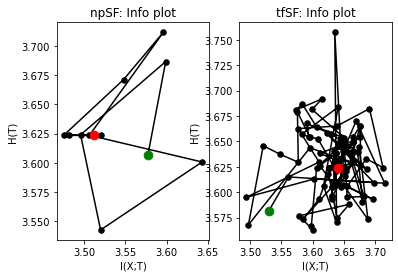

In [11]:
_,ax = plt.subplots(1,2)

ax[0].set_title('npSF: Info plot'); 
ax[0].set_xlabel('I(X;T)'); 
ax[0].set_ylabel('H(T)'); 
ax[0].plot(np_MI_XZs,np_H_Zs,c='black', zorder=0)
ax[0].scatter(np_MI_XZs[1:-1],np_H_Zs[1:-1],c='black',s=30, zorder=1)
ax[0].scatter(np_MI_XZs[0],np_H_Zs[0],c='green',s=75,zorder=2)
ax[0].scatter(np_MI_XZs[-1],np_H_Zs[-1],c='red',s=75,zorder=2)

ax[1].set_title('tfSF: Info plot'); 
ax[1].set_xlabel('I(X;T)'); 
ax[1].set_ylabel('H(T)'); 
ax[1].plot(tf_MI_XZs,tf_H_Zs,c='black', zorder=0)
ax[1].scatter(tf_MI_XZs[1:-1],tf_H_Zs[1:-1],c='black',s=30, zorder=1)
ax[1].scatter(tf_MI_XZs[0],tf_H_Zs[0],c='green',s=75,zorder=2)
ax[1].scatter(tf_MI_XZs[-1],tf_H_Zs[-1],c='red',s=75,zorder=2)

### References

[1] Zennaro, F.M. and Chen, K., 2019. Towards Further Understanding of Sparse Filtering via Information Bottleneck. arXiv preprint arXiv:1910.08964.